Arduino to python communication via Serial cable
-------------

The Raspberry Pis in our network need to be able to establish two-way communication with their Arduinos. Therefore, we need to work out a programmatic interface. After searching online, it seems that the most documented way of doing this involves Python:
http://playground.arduino.cc/Interfacing/Python

It requires the 'pyserial' library (can be installed via pip or downloaded from github https://github.com/pyserial/pyserial)

The official tutorial asks us to connect to the arduino at '/dev/tty.usbserial'. However, this doesn't seem to be the location of the Arduino on my computer. This was helpful:
http://stackoverflow.com/questions/24214643/python-to-automatically-select-serial-ports-for-arduino

Requirements:
- pyserial (requires Python 2.7+ or Python 3.4+)
- python 3.4+ (to run this code)

**Search for available ports**

In [1]:
import serial
import serial.tools.list_ports
import warnings

# Set the baud rate (rate at which data is transmitted). The standard (for Arduinos) seems to be 9600 bits per second, 
# although it also supports 300, 600, 1200, 2400, 4800, 9600, 14400, 19200, 28800, 31250, 38400, 57600, and 115200bps
# Note that the highest rates could cause problems with your hardware.
baud_rate = 9600

port_names = []
devices = []
ports = list(serial.tools.list_ports.comports())
for p in ports:
    # Check to see if the serial port is connected to an Arduino
    if 'Arduino' in p.description:
        port_names.append(p.device)
        devices.append(p.description)

# If we found no arduinos...
if len(devices) == 0:
    # Oops. Check it's plugged in? And check that the usb drivers are installed (normal Arduino software package)
    raise IOError("No Arduino found!")

# If we found too many arduinos...
elif len(devices) > 1:
    warnings.warn('Multiple Arduinos found - using the first')
    
else:
    print('Found device ' + devices[0])
    try:
        ser = serial.Serial(port_names[0], '9600')
        print('Successfully connected to ' + devices[0])
    except serial.SerialException:
        # If you've already connected to the port, the above won't work. In this case, we close the connection 
        # and reconnect
        print('Closing old connection...')
        ser.close()
        ser = serial.Serial(port_names[0], '9600')
        print('Successfully connected to ' + devices[0])

Found device Arduino Uno (COM17)
Successfully connected to Arduino Uno (COM17)


**Experiments - ignore**

In [5]:
ser.write(b'111')

3

In [6]:
ser.close()

In [51]:

data = []

# Read line prints from the beginning. 
for i in range(50):
    decoded = ser.readline().decode()[:-2]
    data.append(int(decoded))


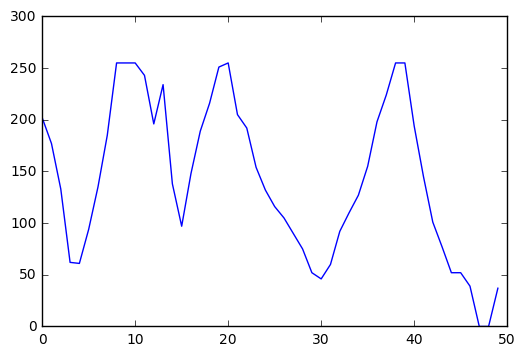

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(range(50), data)
plt.show()

In [42]:
int(ser.readline().decode()[:-2])

209

In [8]:
import pkg_resources
pkg_resources.get_distribution("paho-mqtt").version

'1.2.3'

In [10]:
import paho.Client as client
help(client)

ImportError: No module named 'paho.Client'

In [18]:
import paho.mqtt.client as paho
paho.MQTT

In [17]:
help(paho)

Help on module paho.mqtt.client in paho.mqtt:

NAME
    paho.mqtt.client

DESCRIPTION
    This is an MQTT v3.1 client module. MQTT is a lightweight pub/sub messaging
    protocol that is easy to implement and suitable for low powered devices.

CLASSES
    builtins.ValueError(builtins.Exception)
        WebsocketConnectionError
    builtins.object
        Client
            Mosquitto
        MQTTMessage
        MQTTMessageInfo
        WebsocketWrapper
    
    class Client(builtins.object)
     |  MQTT version 3.1/3.1.1 client class.
     |  
     |  This is the main class for use communicating with an MQTT broker.
     |  
     |  General usage flow:
     |  
     |  * Use connect()/connect_async() to connect to a broker
     |  * Call loop() frequently to maintain network traffic flow with the broker
     |  * Or use loop_start() to set a thread running to call loop() for you.
     |  * Or use loop_forever() to handle calling loop() for you in a blocking
     |  * function.
     |  * 

## Cloud MQTT Broker

The cloud runds the **MQTT Broker**, along with any diagnostics/control and frontend webapps. Our cloud broker is a VM service provided by our organisation (Scientific Computing, STFC). Specifics can be found at https://cloud.stfc.ac.uk/.

## Setting up the cloud

**Basic installation**

Run the commands:
- sudo apt-get update
- sudo apt-get upgrade
- sudo apt-get install mosquitto mosquitto-clients

Edit the config file in /etc/mosquitto/mosquitto.conf, adding the lines:
- persistence true
- persistence_location /var/lib/mosquitto/
- persistence_file mosquitto.db
- log_dest syslog
- log_dest stdout
- log_dest topic
- log_type error
- log_type warning
- log_type notice
- log_type information
- connection_messages true
- log_timestamp true
- allow_anonymous true

And run 
- /sbin/ldconfig


You can listen in on the status of the broker using 
- mosquitto_sub -t '$SYS/#' -v

At this point, it is possible to publish/subscribe using 
- mosquitto_sub -h localhost -p 1883 -t test
- mosquitto_sub -h localhost -p 1883 -t test -m 'Hello World'

**Python**

Run the commands:
- sudo apt-get install python3-pip
- sudo pip3 install paho-mqtt

Paho-MQTT will not work out of the box because our VM is only able to run Ubuntu 14.04. The only available version of mosquitto for this distro uses MQTT version 3.1. rather than the current 3.1.1.

Therefore, whenever you want to create a new MQTT Client, you will need to specify the protocol using:

```python
import paho.mqtt.client as mqtt

def on_connect(client, userdata, rc):
    print('connected')
    client.subscribe("$SYS/#")

def on_message(client, userdata, msg):
    print(msg.topic + " " + str(msg.payload))

client = mqtt.Client(protocol=mqtt.MQTTv31)
client.on_connect = on_connect
client.on_message = on_message

client.connect("localhost", 1883, 60)

client.loop_forever()
``` 

**Web frontend**

Because I am a lazy person, we are going to use the Flask-MQTT module (https://github.com/MrLeeh/Flask-MQTT). 

Run the commands:
- sudo pip3 install Flask-MQTT
- sudo pip3 install eventlet
- sudo pip3 install flask
- sudo pip3 install typing
- sudo pip3 install flask_socketio
- sudo pip3 install flask_bootstrap
- sudo pip3 install flask_socketio

To make the example file work, we need to modify it to match the older protocol
```python

# Finally, need this so that we can change the protocol
from paho.mqtt.client import Client, MQTTv31

# Initialise the client WITHOUT the app
mqtt = Mqtt()

# Perform open heart surgery on the brand new object, setting the protocol to the old version
mqtt.client = Client(protocol=MQTTv31)

# Now we initialise it with the app
mqtt.init_app(app)
```

The app can be run with 
- python3 app.py

![](Architecture.png)

## Smart agents

In this context, a smart agent is a device with an operating system. Our smart agents are Raspberry Pis running Raspbian and PCs running varients of Windows and Linux. A smart agent will generally have TCP/IP networking to communicate with ohter smart agents and the **cloud**. It may also communicate with **edge devices** via bluetooth or serial cables.

In their simplest form, smart agents act as intermediaries between their connected edge devices and the cloud, providing networking capabilities and security that would be impossible for the more limited edge devices.

**Communication with the cloud**

All communication with the cloud is via the MQTT protocol over TCP/IP. The cloud acts as a **MQTT Broker**, so the smart agents need only publish and subscribe as appropriate.

**Communication with edge devices: Bluetooth**

A smart agent can connect up to seven devices in a Bluetooth piconet. The smart agent scans for devices with a friendly name matching a predefined address pattern, and then attempts to connect.

This approach has its limitations. Each of our smart agents has a single Bluetooth chip. This means that the agent cannot scan for devices and receive/send messages concurrently. Since scanning takes approx 20 seconds, regular scanning has an adverse effect on real-time communications. Since communications are buffered, it might be possible to cope with a backlog - but there would be a 20s delay involved.

Because of the scanning problem, it is preferable that the smart agent relay and the edge devices do not move relative to each other, and that the smart agent is provided with a list of devices that it should be connected to, to prevent unnecessary scanning. While this seems restrictive, it might work adequately for a variety of use cases - such as statically placed sensors in a house or vehicle controlled by a central smart agent.

**Communication with edge devices: Serial cable**

The simplest smart agent - edge device connection is via serial cable. While this may not be practical for some applications, it does allow for a stable connection with low device discovery costs and a very high maximum rate of data transfer. It also solves the power problem, since the smart agent and edge device(s) can be powered by the same source (normally a mains power socket).

**Code**

All our code for the smart agents is written in Python 3. We make use of the Pybluez library [See installation notes] to handle bluetooth connections.

## Edge devices

Edge devices do not have an operating system. Usually they are microcontrollers with one or more inputs and outputs (e.g. light intensity sensor, LED, pushbutton). The microcontrollers that we have available are Arduino Unos.

Edge devices cannot directly communicate with the **cloud**. Instead, they communicate with a **smart agent** which then relays their messages. Communication is over serial, or via a bluetooth chip if the microcontroller is adequately equipped (e.g. with a HC-05 chip or similar). Messages are packages as JSON objects - edge devices have no knowledge of the MQTT protocol.

In [21]:
7*8*3


168

In [22]:
8*8*3

192

In [23]:
21*24


504

In [24]:
400/9

44.44444444444444

In [25]:
44.44*8.5

377.74

In [26]:
20*24

480

In [27]:
25*9

225